In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, balanced_accuracy_score

from sklearn.model_selection import train_test_split

In [2]:
df_vfc = pd.read_csv("vfc_dataset_janela_35.csv")

In [3]:
df_vfc.columns

Index(['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
       'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr',
       'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu',
       'total_power', 'vlf', 'labels'],
      dtype='object')

In [4]:
cols = ['mean_nni', 'sdnn','sdnn', 'median_nni','total_power', 'lf', 'hf']
x_train, x_test, y_train, y_test = train_test_split(df_vfc[cols], df_vfc['labels'], random_state=42)

In [5]:
df_vfc['labels'].value_counts()

0    2072
1      40
Name: labels, dtype: int64

In [6]:
df_vfc[cols].isin([np.nan, np.inf, -np.inf]).sum()

mean_nni       0
sdnn           0
sdnn           0
median_nni     0
total_power    0
lf             0
hf             0
dtype: int64

In [7]:
n_iter = 20

### Random Forest Classifier

In [8]:
param_search = {'n_estimators': [400],
                  'oob_score': [False],
                  'criterion': ['gini'],
                  'bootstrap':[True],
                  'class_weight':['balanced_subsample'],
                  'min_weight_fraction_leaf':[0, 0.1, 0.2, 0.3, 0.4, 0.5], 
                  'min_impurity_decrease':[0, 0.1],
                  'min_samples_split': [10, 30, 60, 80],
                  'min_samples_leaf': [10, 30, 60, 80]
                 }
            
cv = RepeatedStratifiedKFold(n_splits=5, 
                    n_repeats=3, 
                    random_state=42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs=1),
                        param_distributions=param_search,
                        n_iter=n_iter,
                        scoring='f1',
                        random_state=42,
                        n_jobs=-1,
                        cv=cv)

rs_rf.fit(x_train, y_train)

model, best_score = rs_rf.best_estimator_, rs_rf.best_score_

y_pred_test_rf = model.predict(x_test)
y_pred_train_rf = model.predict(x_train)

In [9]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_test_rf))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_rf))

Verificar overfitting do modelo
Balanced Acc. Test:  0.7671814671814672
Balanced Acc. Train:  0.9332046332046332


In [10]:
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       518
           1       0.15      0.60      0.24        10

    accuracy                           0.93       528
   macro avg       0.57      0.77      0.60       528
weighted avg       0.98      0.93      0.95       528



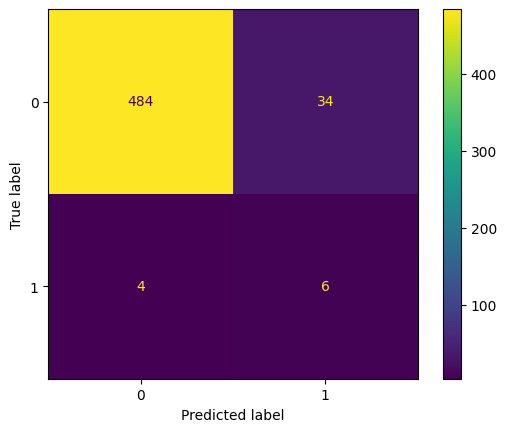

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_rf)

### LogisticRegression

In [12]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
y_pred_train_lr = lr.predict(x_train)

In [13]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_lr))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_lr))

Verificar overfitting do modelo
Balanced Acc. Test:  0.5
Balanced Acc. Train:  0.5


In [14]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       518
           1       0.00      0.00      0.00        10

    accuracy                           0.98       528
   macro avg       0.49      0.50      0.50       528
weighted avg       0.96      0.98      0.97       528



c:\Users\Ana\Documents\biomedica\informatica_medica\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ana\Documents\biomedica\informatica_medica\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ana\Documents\biomedica\informatica_medica\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

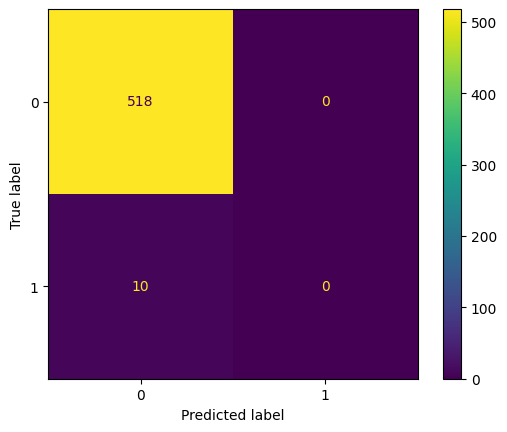

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)

### KNeighborsClassifier

In [16]:
param_search = {'n_neighbors': np.arange(5, 100,5),
                'weights':['uniform', 'distance'],
                'algorithm':['auto']
                }
            
cv = RepeatedStratifiedKFold(n_splits=5, 
                    n_repeats=3, 
                    random_state=42)



rs_neigh = RandomizedSearchCV(KNeighborsClassifier(n_jobs=1),
                        param_distributions=param_search,
                        n_iter=n_iter,
                        scoring='f1',
                        random_state=42,
                        n_jobs=-1,
                        cv=cv)

rs_neigh.fit(x_train, y_train)

model, best_score = rs_neigh.best_estimator_, rs_neigh.best_score_

y_pred_test_neigh = model.predict(x_test)
y_pred_train_neigh = model.predict(x_train)

In [17]:
print("Verificar overfitting do modelo")
print("Balanced Acc. Test: ", balanced_accuracy_score(y_test, y_pred_test_neigh))
print("Balanced Acc. Train: ", balanced_accuracy_score(y_train, y_pred_train_neigh))

Verificar overfitting do modelo
Balanced Acc. Test:  0.49903474903474904
Balanced Acc. Train:  1.0


In [18]:
print(classification_report(y_test, y_pred_test_neigh))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       518
           1       0.00      0.00      0.00        10

    accuracy                           0.98       528
   macro avg       0.49      0.50      0.49       528
weighted avg       0.96      0.98      0.97       528



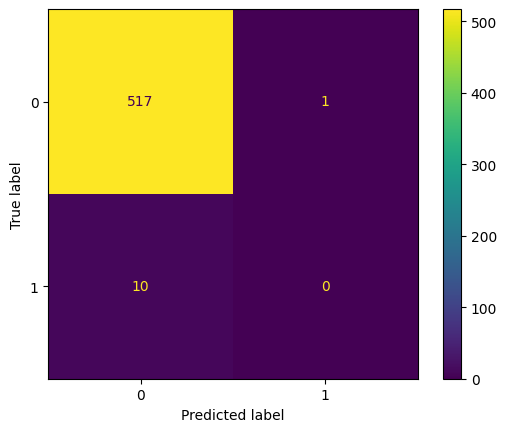

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_neigh)